In [1]:
import os
import math
import random
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T

device = torch.device("cuda")

In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torchvision.transforms as T

# pip install facenet-pytorch
# ?MTCNN

mtcnn  = MTCNN(post_process=False, keep_all = True)
resnet = InceptionResnetV1(pretrained='vggface2').eval()

path_to_data = "input/data/train/images/"
image_path = "000001_female_Asian_45"
file_names = ["normal", "mask1", "mask2", "mask3", "mask4", "mask5", "incorrect_mask"]
extensions = [".jpg"]
path = os.path.join(path_to_data, image_path, file_names[1] + extensions[0])

img = Image.open(path)

boxes, probs, points = mtcnn.detect(img, landmarks=True)

print(boxes, probs, points)

[[109.15015 162.51039 244.78928 328.02164]] [0.9985764] [[[147.66724 236.42017]
  [209.51453 235.7254 ]
  [173.46532 265.2219 ]
  [151.62935 300.90137]
  [198.59555 300.5578 ]]]


In [3]:
print(mtcnn)

MTCNN(
  (pnet): PNet(
    (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=10)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=16)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (prelu3): PReLU(num_parameters=32)
    (conv4_1): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
    (softmax4_1): Softmax(dim=1)
    (conv4_2): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  )
  (rnet): RNet(
    (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
    (prelu1): PReLU(num_parameters=28)
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
    (prelu2): PReLU(num_parameters=48)
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv3): Conv2d(48, 64,

## Proposal Network (p-net)

![img-pnet](https://miro.medium.com/max/1400/1*6xkYymO5qetLLjUt0MYJXg.jpeg)

* This first stage is a fully convolutional network (FCN). The difference between a CNN and a FCN is that a fully convolutional network does not use a dense layer as part of the architechture. 

* This Proposal Network is used to obtain candidate windows and their bounding box regression vectors. [Reference](https://medium.com/@iselagradilla94/multi-task-cascaded-convolutional-networks-mtcnn-for-face-detection-and-facial-landmark-alignment-7c21e8007923)

* Bounding box regression is a popular technique to predict the localization of boxes when the goal is detecting an object of some pre-defined class, in this case faces. 

* The final output of this stage is all candidate windows after refinement to downsize the volume of candidates.

## Refine Network (r-net)

![img-rnet](https://miro.medium.com/max/1400/1*PoMst7LfCfRSADzSFHXIJg.jpeg)

* All candidates from the P-Net are fed into the Refine Network. Notice that this network is a CNN, not a FCN like the one before since there is a dense layer at the last stage of the network architecture. 

* The R-Net further reduces the number of candidates, performs calibration with bounding box regression and employs non-maximum suppression (NMS) to merge overlapping candidates.

* The R-Net outputs wether the input is a face or not, a 4 element vector which is the bounding box for the face, and a 10 element vector for facial landmark localization.

## Output Network (o-net)

![img-onet](https://miro.medium.com/max/1400/1*GEHEFApb0VF9poTIh1Bmng.jpeg)

* This stage is similar to the R-Net, but this Output Network aims to describe the face in more detail and output the five facial landmarks’ positions for eyes, nose and mouth.

* There are five landmarks: left eye, right eye, nose, left mouth corner and right mouth corner.

## Regarding Outputs

* face classification (2개)

  * y^det = GT에서 얼굴이 있는지 여부(있을때 1, 없을때 0)

  * p = 얼굴이 있을 확률

* bbox regression (4개)

  * 예측한 bbox의 왼쪽상단 x,y좌표

  * 예측한 bbox의 너비와 높이

* face landmark localization (10개)

  * 왼쪽 눈의 x,y 좌표

  * 오른쪽 눈의 x,y 좌표

  * 코의 x,y 좌표

  * 입의 왼쪽 끝 부분의 x,y 좌표

  * 입의 오른쪽 끝 부분의 x,y 좌표

In [4]:
for name, layer in mtcnn.named_parameters():
    print(name, " \t ", layer.size())

pnet.conv1.weight  	  torch.Size([10, 3, 3, 3])
pnet.conv1.bias  	  torch.Size([10])
pnet.prelu1.weight  	  torch.Size([10])
pnet.conv2.weight  	  torch.Size([16, 10, 3, 3])
pnet.conv2.bias  	  torch.Size([16])
pnet.prelu2.weight  	  torch.Size([16])
pnet.conv3.weight  	  torch.Size([32, 16, 3, 3])
pnet.conv3.bias  	  torch.Size([32])
pnet.prelu3.weight  	  torch.Size([32])
pnet.conv4_1.weight  	  torch.Size([2, 32, 1, 1])
pnet.conv4_1.bias  	  torch.Size([2])
pnet.conv4_2.weight  	  torch.Size([4, 32, 1, 1])
pnet.conv4_2.bias  	  torch.Size([4])
rnet.conv1.weight  	  torch.Size([28, 3, 3, 3])
rnet.conv1.bias  	  torch.Size([28])
rnet.prelu1.weight  	  torch.Size([28])
rnet.conv2.weight  	  torch.Size([48, 28, 3, 3])
rnet.conv2.bias  	  torch.Size([48])
rnet.prelu2.weight  	  torch.Size([48])
rnet.conv3.weight  	  torch.Size([64, 48, 2, 2])
rnet.conv3.bias  	  torch.Size([64])
rnet.prelu3.weight  	  torch.Size([64])
rnet.dense4.weight  	  torch.Size([128, 576])
rnet.dense4.bias  	  tor

In [5]:
class PrintOutput:
    def __init__(self):
        self.outputs = []
    
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        print(module_out)
        print(module_out.size())
    
    def clear(self):
        self.outputs = []

print_output = PrintOutput()
mtcnn.onet.dense6_3.register_forward_hook(print_output)
mtcnn.onet.dense6_2.register_forward_hook(print_output)
mtcnn.onet.dense6_1.register_forward_hook(print_output)

In [6]:
boxes, probs, points = mtcnn.detect(img, landmarks=True)

tensor([[-3.2769,  3.2762],
        [-2.4803,  2.4794],
        [ 2.4524, -2.4512]])
torch.Size([3, 2])
tensor([[ 0.0613, -0.0135, -0.1105, -0.0043],
        [ 0.0826, -0.0100, -0.0780,  0.0149],
        [ 0.0855, -0.1640, -0.0801,  0.0058]])
torch.Size([3, 4])
tensor([[0.3008, 0.6757, 0.4572, 0.3248, 0.6095, 0.4405, 0.4363, 0.6151, 0.8313,
         0.8293],
        [0.3281, 0.6981, 0.4962, 0.3730, 0.6601, 0.4533, 0.4329, 0.6134, 0.8425,
         0.8320],
        [0.3551, 0.7729, 0.5098, 0.2762, 0.6449, 0.1982, 0.3103, 0.4840, 0.7011,
         0.7909]])
torch.Size([3, 10])


In [7]:
print(boxes, probs, points, sep = "\n")

[[109.15015 162.51039 244.78928 328.02164]]
[0.9985764]
[[[147.66724 236.42017]
  [209.51453 235.7254 ]
  [173.46532 265.2219 ]
  [151.62935 300.90137]
  [198.59555 300.5578 ]]]


In [8]:
class CustomMTCNN(nn.Module):
    def __init__(self, mtcnn):
        super().__init__()

        
        self.conv1 = nn.Conv2d(3, 64, 3, 1)
        self.conv1.requires_grad_ = False
        with torch.no_grad():
            self.conv1.weight = mtcnn.onet.conv1.weight
            self.conv1.bias = mtcnn.onet.conv1.bias
        
        self.prelu1 = nn.PReLU(64)
        self.prelu1.requires_grad_ = False    
        with torch.no_grad():
            self.prelu1.weight = mtcnn.onet.prelu1.weight
        
        self.pool1 = nn.MaxPool2d(kernel_size = (3, 3), stride = 2, ceil_mode = True)
            
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv2.requires_grad_ = False
        with torch.no_grad():
            self.conv2.weight = mtcnn.onet.conv2.weight
            self.conv2.bias = mtcnn.onet.conv2.bias
            
        self.prelu2 = nn.PReLU(64)
        self.prelu2.requires_grad_ = False
        with torch.no_grad():
            self.prelu2.weight = mtcnn.onet.prelu2.weight
            
        self.pool2 = nn.MaxPool2d(kernel_size = (3, 3), stride = 3, ceil_mode = True)
            
        self.conv3 = nn.Conv2d(64, 64, 3, 1)
        self.conv3.requires_grad_ = False
        with torch.no_grad():
            self.conv3.weight = mtcnn.onet.conv3.weight
            self.conv3.bias = mtcnn.onet.conv3.bias
            
        self.prelu3 = nn.PReLU(64)
        self.prelu3.requires_grad_ = False
        with torch.no_grad():
            self.prelu3.weight = mtcnn.onet.prelu3.weight
            
        self.pool3 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2, ceil_mode = True)
            
        self.conv4 = nn.Conv2d(64, 128, 2, 1)
        with torch.no_grad():
            self.conv4.weight = mtcnn.onet.conv4.weight
            self.conv4.bias = mtcnn.onet.conv4.bias
            
        self.prelu4 = nn.PReLU(128)
        with torch.no_grad():
            self.prelu4.weight = mtcnn.onet.prelu4.weight
            
        self.drop5 = nn.Dropout(p = 0.5)
        self.dense5 = nn.Linear(4608, 256)
        with torch.no_grad():
            # print(mtcnn.onet.dense5.weight.shape)
            # print(self.dense5.weight.shape)
            self.dense5.weight[:, :1152] = mtcnn.onet.dense5.weight
            
            self.dense5.bias[:1152] = mtcnn.onet.dense5.bias
        self.relu5 = nn.ReLU()
            
        self.dense6 = nn.Linear(256, 7)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.prelu1(x)
        x = self.pool1(x)
        x1 = x.detach()
        
        x = self.conv2(x)
        x = self.prelu2(x)
        x = self.pool2(x)
        x2 = x.detach()
        
        x = self.conv3(x)
        x = self.prelu3(x)
        x = self.pool3(x)
        x3 = x.detach()
        
        x = self.conv4(x)
        x = self.prelu4(x)
        x4 = x.detach()
        
        x = x.flatten(start_dim = 1)
        x = self.drop5(x)
        x = self.dense5(x)
        x = self.relu5(x)
        x5 = x.detach()
        
        x = self.dense6(x)
        
        return x, (x1, x2, x3, x4, x5)

In [9]:
custom = CustomMTCNN(mtcnn).to(device)

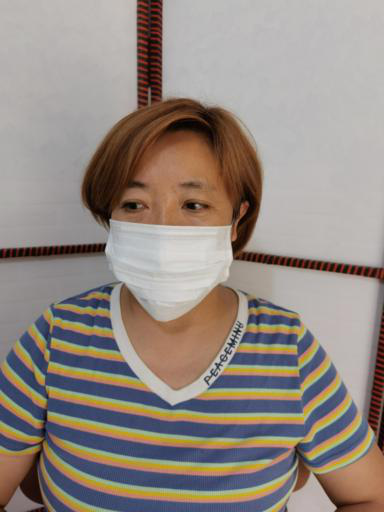

In [10]:
path = os.path.join(path_to_data, image_path, file_names[3] + extensions[0])
img = Image.open(path)
img

In [11]:
x = T.ToTensor()(T.Resize((96, 96), Image.BILINEAR)(T.CenterCrop((384, 384))(img))).unsqueeze(0)
x = x.to(device)

In [12]:
out, additionals = custom(x)
x1, x2, x3, x4, x5 = additionals
print(x1.shape, x2.shape, x3.shape, x4.shape, x5.shape)

torch.Size([1, 32, 47, 47]) torch.Size([1, 64, 15, 15]) torch.Size([1, 64, 7, 7]) torch.Size([1, 128, 6, 6]) torch.Size([1, 256])


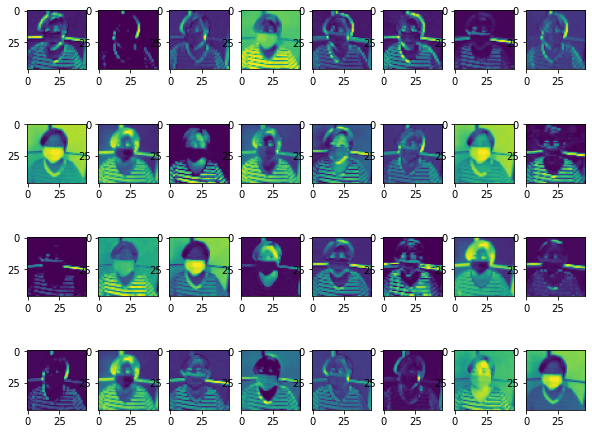

In [13]:
fig, axes = plt.subplots(4, 8, figsize = (10, 8))
for i in range(4):
    for j in range(8):
        idx = i*8 + j
        axes[i][j].imshow(x1[0, idx, :, :].cpu().numpy())

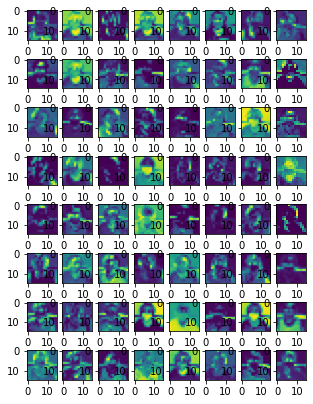

In [14]:
fig, axes = plt.subplots(8, 8, figsize = (5, 7))
for i in range(8):
    for j in range(8):
        idx = i*8 + j
        axes[i][j].imshow(x2[0, idx, :, :].cpu().numpy())

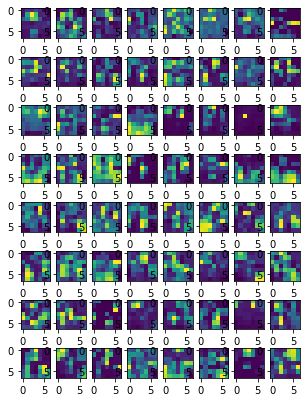

In [15]:
fig, axes = plt.subplots(8, 8, figsize = (5, 7))
for i in range(8):
    for j in range(8):
        idx = i*8 + j
        axes[i][j].imshow(x3[0, idx, :, :].cpu().numpy())

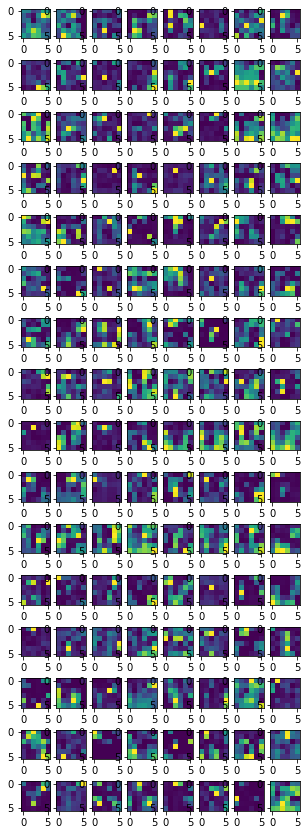

In [16]:
fig, axes = plt.subplots(16, 8, figsize = (5, 15))
for i in range(16):
    for j in range(8):
        idx = i*8 + j
        axes[i][j].imshow(x4[0, idx, :, :].cpu().numpy())

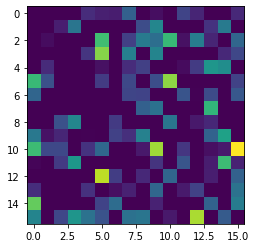

In [17]:
plt.imshow(x5[0].cpu().view(16, 16))

In [22]:
import os
from enum import Enum
from typing import Tuple
from PIL import Image

from torch.utils.data import Dataset, Subset, random_split


class AgeLabels(int, Enum):
    YOUNG = 0
    MIDDLE = 1
    OLD = 2

    @classmethod
    def from_number(cls, value: str) -> int:
        try:
            value = int(value)
        except Exception:
            raise ValueError(f"Age value should be numeric, {value}")

        if value < 30:
            return cls.YOUNG
        elif value < 60:
            return cls.MIDDLE
        else:
            return cls.OLD


class GenderLabels(int, Enum):
    MALE = 0
    FEMALE = 1

    @classmethod
    def from_str(cls, value: str) -> int:
        value = value.lower()
        if value == "male":
            return cls.MALE
        elif value == "female":
            return cls.FEMALE
        else:
            raise ValueError(f"Gender value should be either 'male' or 'female', {value}")


class MaskLabels(int, Enum):
    MASK = 0
    INCORRECT = 1
    NORMAL = 2

class MaskBaseDataset(Dataset):
    num_classes = 3 * 2 * 3

    _file_names = {
        "mask1": MaskLabels.MASK,
        "mask2": MaskLabels.MASK,
        "mask3": MaskLabels.MASK,
        "mask4": MaskLabels.MASK,
        "mask5": MaskLabels.MASK,
        "incorrect_mask": MaskLabels.INCORRECT,
        "normal": MaskLabels.NORMAL
    }

    image_paths = []
    mask_labels = []
    gender_labels = []
    age_labels = []

    def __init__(self, data_dir, mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246), val_ratio=0.2):
        self.data_dir = data_dir
        self.mean = mean
        self.std = std
        self.val_ratio = val_ratio

        self.transform = None
        self.setup()
        self.calc_statistics()

    def setup(self):
        profiles = os.listdir(self.data_dir)
        for profile in profiles:
            if profile.startswith("."):  # "." 로 시작하는 파일은 무시합니다
                continue

            img_folder = os.path.join(self.data_dir, profile)
            for file_name in os.listdir(img_folder):
                _file_name, ext = os.path.splitext(file_name)
                if _file_name not in self._file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                    continue

                img_path = os.path.join(self.data_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                mask_label = self._file_names[_file_name]

                id, gender, race, age = profile.split("_")
                gender_label = GenderLabels.from_str(gender)
                age_label = AgeLabels.from_number(age)
                # age_label = int(age)

                self.image_paths.append(img_path)
                self.mask_labels.append(mask_label)
                self.gender_labels.append(gender_label)
                self.age_labels.append(age_label)

    def calc_statistics(self):
        has_statistics = self.mean is not None and self.std is not None
        if not has_statistics:
            print("[Warning] Calculating statistics... It can take a long time depending on your CPU machine")
            sums = []
            squared = []
            for image_path in self.image_paths[:3000]:
                image = np.array(Image.open(image_path)).astype(np.int32)
                sums.append(image.mean(axis=(0, 1)))
                squared.append((image ** 2).mean(axis=(0, 1)))

            self.mean = np.mean(sums, axis=0) / 255
            self.std = (np.mean(squared, axis=0) - self.mean ** 2) ** 0.5 / 255

    def set_transform(self, transform):
        self.transform = transform

    def __getitem__(self, index):
        assert self.transform is not None, ".set_tranform 메소드를 이용하여 transform 을 주입해주세요"

        image = self.read_image(index)
        mask_label = self.get_mask_label(index)
        gender_label = self.get_gender_label(index)
        age_label = self.get_age_label(index)
        multi_class_label = self.encode_multi_class(mask_label, gender_label, age_label)

        image_transform = self.transform(image)
        return image_transform, mask_label, gender_label, age_label

    def __len__(self):
        return len(self.image_paths)

    def get_mask_label(self, index) -> MaskLabels:
        return self.mask_labels[index]

    def get_gender_label(self, index) -> GenderLabels:
        return self.gender_labels[index]

    def get_age_label(self, index) -> AgeLabels:
        return self.age_labels[index]

    def read_image(self, index):
        image_path = self.image_paths[index]
        return Image.open(image_path)

    @staticmethod
    def encode_multi_class(mask_label, gender_label, age_label) -> int:
        return mask_label * 6 + gender_label * 3 + age_label

    @staticmethod
    def decode_multi_class(multi_class_label) -> Tuple[MaskLabels, GenderLabels, AgeLabels]:
        mask_label = (multi_class_label // 6) % 3
        gender_label = (multi_class_label // 3) % 2
        age_label = multi_class_label % 3
        return mask_label, gender_label, age_label

    @staticmethod
    def denormalize_image(image, mean, std):
        img_cp = image.copy()
        img_cp *= std
        img_cp += mean
        img_cp *= 255.0
        img_cp = np.clip(img_cp, 0, 255).astype(np.uint8)
        return img_cp

    def split_dataset(self) -> Tuple[Subset, Subset]:
        """
        데이터셋을 train 과 val 로 나눕니다,
        pytorch 내부의 torch.utils.data.random_split 함수를 사용하여
        torch.utils.data.Subset 클래스 둘로 나눕니다.
        구현이 어렵지 않으니 구글링 혹은 IDE (e.g. pycharm) 의 navigation 기능을 통해 코드를 한 번 읽어보는 것을 추천드립니다^^
        """
        n_val = int(len(self) * self.val_ratio)
        n_train = len(self) - n_val
        train_set, val_set = random_split(self, [n_train, n_val])
        return train_set, val_set

In [23]:
mask_ds = MaskBaseDataset("input/data/train/images")

transform = T.Compose([T.CenterCrop((384, 384)),
                       T.Resize((96, 96)),
                       T.RandomVerticalFlip(),
                       T.RandomHorizontalFlip(),
                       T.ColorJitter(0.2, 0.2, 0.1, 0.05),
                       T.ToTensor()])

mask_ds.set_transform(transform)

In [24]:
train_ds, valid_ds = mask_ds.split_dataset()

In [25]:
BATCH_SIZE = 256
train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size = BATCH_SIZE, shuffle=False)

In [26]:
for img, m_lbl, g_lbl, a_lbl in train_dl:
    print(img.shape)
    print(m_lbl.shape)
    print(g_lbl.shape)
    print(a_lbl.shape)
    break

torch.Size([256, 3, 96, 96])
torch.Size([256])
torch.Size([256])
torch.Size([256])


In [37]:
model = CustomMTCNN(mtcnn).to(device)

In [38]:
loss_fn1 = nn.CrossEntropyLoss()
loss_fn2 = nn.BCEWithLogitsLoss()
loss_fn3 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [ ]:
NUM_EPOCHS = 100
losses = []
m_losses = []
g_losses = []
a_losses = []
val_losses = []
val_m_losses = []
val_g_losses = []
val_a_losses = []


for epoch in range(NUM_EPOCHS):
    model.train()
    for img, m_lbl, g_lbl, a_lbl in train_dl:
        img = img.to(device)
        m_lbl = m_lbl.to(device)
        g_lbl = g_lbl.to(device, dtype = torch.float)
        a_lbl = a_lbl.to(device)
        
        optimizer.zero_grad()
        
        out, _ = model(img)
        
        m_loss = loss_fn1(out[:, 0:3], m_lbl)
        g_loss = loss_fn2(out[:, 3], g_lbl)
        a_loss = loss_fn3(out[:, 4:7], a_lbl)
        
        loss = m_loss + g_loss + a_loss

        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        m_losses.append(m_loss.item())
        g_losses.append(g_loss.item())
        a_losses.append(a_loss.item())
        
    print(losses[-1], m_losses[-1], g_losses[-1], a_losses[-1])
        
    model.eval()
    for img, m_lbl, g_lbl, a_lbl in valid_dl:
        img = img.to(device)
        m_lbl = m_lbl.to(device, dtype = torch.float)
        g_lbl = g_lbl.to(device, dtype = torch.float)
        a_lbl = a_lbl.to(device, dtype = torch.float)
        
        with torch.no_grad():
            out, _ = model(img)
            
            m_loss = loss_fn1(out[:, 0:3], m_lbl)
            g_loss = loss_fn2(out[:, 3], g_lbl)
            a_loss = loss_fn3(out[:, 4:7], a_lbl)
            
            loss = m_loss + g_loss + a_loss
        
        val_losses.append(loss.item())
        val_m_losses.append(m_loss.item())
        val_g_losses.append(g_loss.item())
        val_a_losses.append(a_loss.item())
        
    
    print(val_losses[-1], val_m_losses[-1], val_g_losses[-1], val_a_losses[-1])

In [ ]:
plt.plot(losses)

In [ ]:
plt.plot(m_losses)
plt.plot(g_losses)
plt.plot(a_losses)

In [ ]:
plt.plot(accuracy)

In [ ]:
plt.plot(val_losses)

In [ ]:
plt.plot(val_accuracy)

In [ ]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [ ]:
# meta 데이터와 이미지 경로를 불러옵니다.
test_dir = "input/data/eval"
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = T.Compose([
    T.CenterCrop((384, 384)),
    T.Resize((48, 48), Image.BILINEAR),
    T.ToTensor(),
    T.Normalize(mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

![img](https://s3-ap-northeast-2.amazonaws.com/aistages-public-junyeop/app/Users/00000025/files/56bd7d05-4eb8-4e3e-884d-18bd74dc4864..png)

In [ ]:
image_dir = os.path.join(test_dir, 'images')

In [ ]:
img_path = os.path.join(image_dir, "a62bf46deae4e95e5ea91e9dcb731c2d591d0a25.jpg")
img = Image.open(img_path)
img